In [1]:
import pandas as pd
import numpy as np
from dtaidistance import dtw
import seaborn as sns
import json

In [2]:
data_all = pd.read_csv('./data/sampled_data_5.csv',header=0)

print("There are "+str(len(data_all['kmer'].unique()))+" unique kmers")
print("data dimension: "+str(data_all.shape))
data_all.head()


There are 256 unique kmers
data dimension: (1280, 3)


,read_ID,kmer,values
0,@8a85e853-5be8-4b58-b2d6-c42b920786c1_Basecall...,AACAA,628_671_629_658_673_718_717_698_691_700_710_69...
1,@1d20b26f-6849-41d5-b0b8-0bf9de6ad085_Basecall...,AACAA,664_710_629_654_665_654_649_656_715_707_601_64...
2,@f43fe510-e8e9-4565-a75c-8aa075bbadf8_Basecall...,AACAA,568_568_585_556_583_566_589_568_566_545_541_53...
3,@a360a391-486c-468d-8a60-75d72ce55459_Basecall...,AACAA,635_633_653_623_635_650_635_627_633_607_621_53...
4,@f3365a14-afe9-480b-8fe9-5754ead63217_Basecall...,AACAA,664_629_655_665_652_663_654_654_654_667_650_68...


In [4]:
ave_dist = []
median_dist = []
min_dist = []
max_dist = []
q1_dist = []
q3_dist = []

for kmer in data_all['kmer'].unique():
    data = data_all.loc[data_all['kmer']==kmer]
    series_data = []
    for i in data.index:
        val = map(int,data.loc[i,'values'].split("_"))
        series_data.append(np.array(list(val), dtype=np.double))
    # DTW computation
    ds = dtw.distance_matrix_fast(series_data,show_progress=True)
    y = ds[np.triu_indices(ds.shape[0],k=1)]
    
    ave_dist.append(np.average(y))
    median_dist.append(np.median(y))
    min_dist.append(np.min(y))
    max_dist.append(np.max(y))
    q1_dist.append(np.percentile(y,25))
    q3_dist.append(np.percentile(y,75))
    
    
    ## Fill out the whole symmetrical matrix and output it for t-sne 
    ds[np.tril_indices(ds.shape[0],k=-1)] = ds.T[np.tril_indices(ds.shape[0],k=-1)]
    np.fill_diagonal(ds,0)
    ds = pd.DataFrame(ds)
    ds.columns = data.index
    ds['index'] = data.index
    ds = ds.set_index('index')
    filename = './d3/data/dist_matrix/'+kmer+'.csv'
    ds.to_csv(filename, index=False)
    

/home/ratanond/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


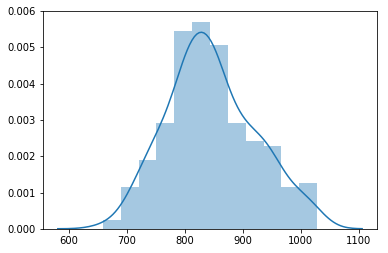

In [30]:
sns.distplot(ave_dist)

In [22]:
ave_df = pd.DataFrame(list(d.items()),columns=['kmer','ave_dist'])

In [32]:
ave_dict = ave_df.to_dict('records')

In [33]:
with open('./data/ave_dict.json','w') as fout:
    json.dump(ave_dict,fout)

In [5]:
## creating a dataset for boxplot
kmer_list = data_all['kmer'].unique().tolist()
boxplot_dict = dict([('kmer', kmer_list),
                          ('min', min_dist),
                          ('max', max_dist),
                          ('median', median_dist),
                          ('q1', q1_dist),
                          ('q3', q3_dist)    
                    ])

boxplot_df = pd.DataFrame.from_dict(boxplot_dict)
boxplot_df.to_csv('./d3/data/boxplot_data.csv', index=False)

In [3]:
## creating datasets for drawing raw signals in d3
data_all.kmer.unique()
for kmer in data_all.kmer.unique():
    data_kmer = data_all.loc[data_all['kmer']==kmer,:]
    filename = './d3/data/raw_signal/'+kmer+'_signal.csv'
    data_kmer.to_csv(filename, index=False)
